# Preprocessing

TODO: 
- make number of columns of training examples and training labels match
- train test split
- execute the loops on test audio and test labels (colab)

## training examples (audio)
- load audio
- perform cqt transform
- add some frequency bins to match 128 frequency bins of MIDI standard
- save the resulting matrix (cqt spectrogram)

## training labels (csv)
- load note data
- convert to seconds
- convert into indicator vector (128 lines x N columns, lines are notes, columns are time intevals, 1 and 0 to represent not being played or not) (same as defined for audio sequences)

# Processing audio
## Computing and saving CQT for each audio file

In [1]:
import os
import gc
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm

train_audio_dir = 'datasets/musicnet/musicnet/train_data'
train_cqt_dir = 'datasets/musicnet/musicnet/train_cqt/'

if not os.path.exists(train_cqt_dir):
    os.makedirs(train_cqt_dir)

LIMIT = 1000 # limit on number of files to load
count = 0
n_of_files_already_processed = len([name for name in os.listdir(train_cqt_dir) if os.path.isfile(os.path.join(train_cqt_dir, name))])
files_to_process = os.listdir(train_audio_dir)[n_of_files_already_processed:]

# loop over audio files in the training set
for filename in tqdm(files_to_process, total=len(files_to_process)):
    if count >= LIMIT:
        break
    else:
        # get the audio
        filepath = os.path.join(train_audio_dir, filename)
        audio_data, sr = librosa.load(filepath, sr=None)

        # perform ConstantQ transform
        # midi standard goes from C0 to F#10 for 128 pitch total
        C0_freq = 16.35	# starting frequency
        sr = 44100      # Sampling rate
        TIMESTEP = 0.10 # Desired TIMESTEP in seconds
        # Calculate the number of samples for the desired TIMESTEP
        hop_length = int(sr * TIMESTEP)
        cqt_data = librosa.cqt(audio_data, fmin=C0_freq, n_bins=125, sr=sr, hop_length=hop_length)

        # CQT can't compute above 125 frequency bins so will add lines of 0s manually
        # so we'll 3 add rows to match 128 frequency bins to match the MIDI file standard
        zeros = np.zeros((3, cqt_data.shape[1]))
        cqt_data = np.vstack((cqt_data, zeros))

        # Trying things for memory
        # Clear variables no longer needed
        del audio_data
        gc.collect()  # Perform garbage collection

        # save the cqt array
        np.save(train_cqt_dir + filename.split('.')[0], cqt_data)
        count += 1

        # Clear variables and perform garbage collection
        del cqt_data
        gc.collect()

100%|██████████| 278/278 [48:37<00:00, 10.49s/it] 


## How to load the arrays

In [55]:
import os
import numpy as np

train_cqt_dir = 'datasets/musicnet/musicnet/train_cqt/'

# load the array
file = os.listdir(train_cqt_dir)[0]
filepath = train_cqt_dir + file
print(filepath)

cqt_array = np.array(np.load(filepath))
print(cqt_array)
print(cqt_array.shape) # freq_bins X time_intervals (one interval = 0.1s)

datasets/musicnet/musicnet/train_cqt/1727.npy
[[ 2.57428765e-04-2.22782124e-04j -5.93174540e-04-3.43217507e-05j
   5.20157162e-04+5.71272685e-04j ...  5.13322302e-05-6.84659483e-07j
  -5.35671388e-05-8.05060699e-06j  5.88376097e-05+4.16767107e-05j]
 [-2.69114738e-04+3.92691763e-05j -3.82055550e-05+6.25704299e-04j
   9.04196466e-04+1.21861180e-04j ... -6.72054157e-05+1.06477870e-04j
   7.02706820e-05+1.08719127e-04j  1.41021737e-04-3.36765697e-05j]
 [ 1.82399323e-04+4.40537144e-04j  8.38531647e-04+2.32781895e-04j
   1.03155267e-03-7.93580606e-04j ... -5.60147600e-05+2.10249462e-04j
   1.74279354e-04+1.81913929e-04j  2.47208431e-04-4.66376296e-05j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
 

## Very plot

/tmp/ipykernel_5809/200380037.py:4: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(cqt_array, ref=np.max), sr=sr, hop_length=hop_length, x_axis='time', y_axis='cqt_note')
/tmp/ipykernel_5809/200380037.py:4: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(librosa.amplitude_to_db(cqt_array, ref=np.max), sr=sr, hop_length=hop_length, x_axis='time', y_axis='cqt_note')


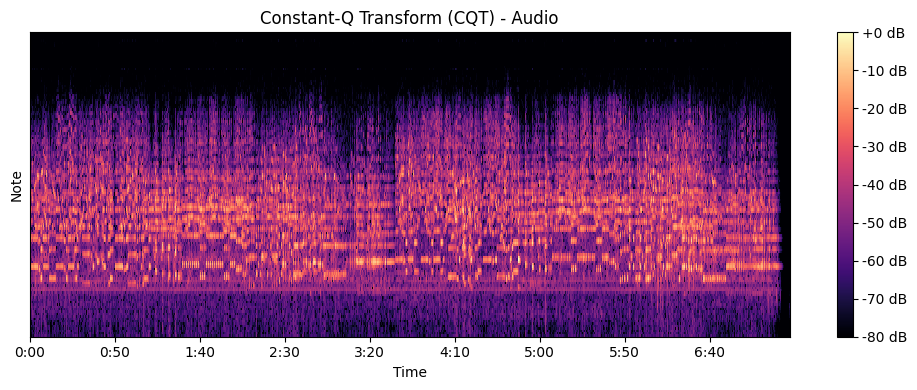

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(cqt_array, ref=np.max), sr=sr, hop_length=hop_length, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q Transform (CQT) - Audio')
plt.tight_layout()
plt.show()

# Processing labels

## First testing things with one file then looping over all files

In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("datasets/musicnet/musicnet/train_labels/1727.csv", delimiter=",")

# Convert times to seconds, i don't know what unit the times are, but i know
# the factor to get seconds by looking at metadata and labels and comparing
# duration of song and end_time of last note
df[['start_time', 'end_time']] /= 43447
# print(df)

# Extract the required columns: start_time, end_time, note
note_list = df[["start_time", "end_time", "note"]].values.tolist()

# Print the first few rows to verify the data
print(note_list[:5])

In [ ]:
def convert_to_matrix(notes, timestep):
    """
    Convert the note event to a matrix representing
    note activation at each timestep. One column represent
    1 time interval and will be filled with 1 or 0 on the line
    which corresponds to a note being active or not.

    notes: list of list containing these [note_start, note_end, note_pitch]
    timestep: in seconds
    """
    import sys
    # Find the total duration of the notes
    total_duration = max(note[1] for note in notes)
    
    # Calculate the number of timesteps(s)
    num_timesteps = int(total_duration / timestep) + 1

    # Create an empty matrix filled with zeros
    n_of_notes = 128 # as per the midi standard
    matrix = [[0] * num_timesteps for _ in range(n_of_notes)]
    
    # Populate the matrix with ones where notes are played
    for note in notes:
        # range where a note is active
        start_idx = int(note[0] / timestep)
        end_idx = int(note[1] / timestep)

        # fill in 1s for all the corresponding timesteps at the line
        # which corresponds to the pitch
        for timestep_idx in range(start_idx, end_idx + 1):
            pitch_idx = int(note[2])
            try:
                matrix[pitch_idx][timestep_idx] = 1
            except Exception as err:
                print(err)
                print(pitch_idx, timestep_idx)
                sys.exit()

    return matrix

mat = convert_to_matrix(note_list, TIMESTEP)

In [ ]:
print(np.array(mat).shape)
time_interval = [note_bin[0] for note_bin in mat]
len(time_interval)
print([(i, val) for (i, val) in enumerate(time_interval) if val==1])

# Testing is over now for the real loop

In [ ]:
import os
import pandas as pd

# Directory containing the CSV files
directory = "datasets/musicnet/musicnet/train_labels/"
out_directory = "datasets/musicnet/musicnet/train_labels_bettered/"

if not os.path.exists(out_directory):
    os.makedirs(out_directory)

# Loop over files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Load the CSV file into a DataFrame
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath, delimiter=",")

        # Convert times to seconds, i don't know what unit the times are, but i know
        # the factor to get seconds by looking at metadata and labels and comparing
        # duration of song and end_time of last note
        df[['start_time', 'end_time']] /= 43447

        # Extract the required columns: start_time, end_time, note
        note_list = df[["start_time", "end_time", "note"]].values.tolist()

        # Print the first few rows to verify the data
        # print(note_list[:5])

        # process the note list to turn into a timestepped matrix
        mat = convert_to_matrix(note_list, TIMESTEP)

        # Save the resulting matrix in a CSV file with the same name
        output_filename = os.path.splitext(filename)[0] + "_processed.csv"
        output_filepath = os.path.join(out_directory, output_filename)
        pd.DataFrame(mat).to_csv(output_filepath, index=False, mode='w')

## How to load the data

In [36]:
# load one file of labels
df = pd.read_csv("datasets/musicnet/musicnet/train_labels_bettered/1727_processed.csv", delimiter=",")
print(df)

# print note pitch being played at a certain time interval
matrix_list = df.values.tolist()
interval_number = 53
# take a column of the matrix which correspond to a certain time interval
time_interval = [note_bin[interval_number] for note_bin in matrix_list]
print([(i, val) for (i, val) in enumerate(time_interval) if val==1])

     0  1  2  3  4  5  6  7  8  9  ...  4461  4462  4463  4464  4465  4466  \
0    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
..  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
123  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
124  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
125  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
126  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
127  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

     4467  4468  4469  4470  
0       0     0     0     0  
1  

## for later reconverting (frequency X time_interval) matrix back to a [note_start, note_end, note_pitch] matrix, from which we can generate a midi easily (midi_from_note_matrix.py)

In [53]:
def convert_to_notes(matrix, timestep):
    notes = []

    # Iterate through each row in the matrix
    for pitch_idx, pitch_row in enumerate(matrix):
        start_time = None

        # Iterate through each column (timestep) in the row
        for timestep_idx, value in enumerate(pitch_row):
            if value == 1:
                # Record the start time if not already set
                if start_time is None:
                    start_time = timestep_idx * timestep

                # if we're at the end of the row
                if (timestep_idx + 1) == len(pitch_row):
                    end_time = (timestep_idx + 1) * timestep
                    pitch = pitch_idx
                    notes.append([round(start_time, 2), round(end_time, 2), pitch])
                    start_time = None

            # if we have a start_time AND value was 0 then record the note
            elif start_time is not None:
                end_time = timestep_idx * timestep
                pitch = pitch_idx
                notes.append([round(start_time, 2), round(end_time, 2), pitch])
                start_time = None

    # sort by start time
    sorted_notes = sorted(notes, key=lambda x: x[0])       
    return sorted_notes

# Example usage:
# rows are frequency bins (notes), and columns are time intervals
matrix = [[1, 1, 0, 1, 1],
          [0, 1, 1, 0, 1],
          [1, 0, 0, 1, 0]]

timestep = 0.1

result_notes = convert_to_notes(matrix, timestep)

# Print the resulting list of notes
print('note_start, note_end, note_pitch_idx\n\
(times are in seconds pitch index refers to the MIDI standard)')
for note in result_notes:
    print(note)

note_start, note_end, note_pitch_idx
(times are in seconds pitch index refers to the MIDI standard)
[0.0, 0.2, 0]
[0.0, 0.1, 2]
[0.1, 0.3, 1]
[0.3, 0.5, 0]
[0.3, 0.4, 2]
[0.4, 0.5, 1]
